# Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
from matplotlib import pyplot as plt
import glob
import json

physical_devices = tf.config.list_physical_devices('GPU')
try:
  # Disable all GPUS
  tf.config.set_visible_devices([], 'GPU')
  visible_devices = tf.config.get_visible_devices()
  for device in visible_devices:
    assert device.device_type != 'GPU'
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

print(tf.config.get_visible_devices('GPU'))
print(tf.config.get_visible_devices('CPU'))

In [2]:
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.get_visible_devices('GPU')

2.2.0-rc3


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Metadata

In [3]:
grid_width = 18
grid_height = 18
inout_layers = 2

image_width = 728
image_height = 728

batch_size=20

# Prepare Data

In [4]:
base_path = '/home/julian/Documents/Studium/MT-Masterarbeit/Data/LASTEN2/train'

files = glob.glob(base_path+'/*.json')

file_length =len(files)

x_position = np.full((file_length, grid_height, grid_width), 0)
y_position = np.full((file_length, grid_height, grid_width), 0)

for file_id, file in enumerate(files):
    with open(file) as json_file:
        data = json.load(json_file)
        
        for key, value in data.items():
            key = int(key)
        
            
            y = key // grid_height 
            x = key % grid_width

            x_position[file_id][y][x] = value[0]
            y_position[file_id][y][x] = value[1]
            
np.save('x_pos', x_position)
np.save('y_pos', y_position)

In [5]:
x_position = np.load('x_pos.npy')
y_position = np.load('y_pos.npy')

x_position = x_position / image_width
y_position = y_position / image_height

a = x_position

# Zero padding
x_position = np.pad(x_position,[(0,0),(1,1),(1,1)],constant_values=0)
y_position = np.pad(y_position,[(0,0),(1,1),(1,1)],constant_values=0)

x_position = x_position[:,:,:,np.newaxis]
y_position = y_position[:,:,:,np.newaxis]

xy_data = np.concatenate((x_position, y_position), axis=3)

dataset = tf.data.Dataset.from_tensor_slices(xy_data)
dataset = dataset.shuffle(buffer_size=1024).batch(batch_size).prefetch(32)

In [6]:
def reconstruct_image(x_position, y_position):
    # Unpad
    x_position = x_position[1:-1, 1:-1]
    y_position = y_position[1:-1, 1:-1]
    
    image = np.zeros((image_height, image_width))
    
    for x, y in zip(x_position.flatten(), y_position.flatten()):
        
        x = int(x*image_width)
        y = int(y*image_height)
        
        if x >= 20 and y>= 20:
            image[y][x] = 1
        
    image = endolas.utils.apply_smoothing(image, sigma=2, sigma_back=15)
    
    return image

# Discriminator

In [7]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(grid_height+2, grid_width+2, 2)),
        layers.Conv2D(64, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.GlobalMaxPooling2D(),
        #layers.Flatten(),
        #layers.Dropout(0.4),
        layers.Dense(1),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 10, 10, 64)        2112      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 5, 128)         131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 5, 5, 128)         0         
_________________________________________________________________
global_max_pooling2d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 133,441
Trainable params: 133,441
Non-trainable params: 0
_______________________________________________

# Generator

In [8]:
latent_dim = 6

x_factor = (grid_height+2) // 4
y_factor = (grid_width+2) // 4

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        # We want to generate 128 coefficients to reshape into a 7x7x128 map
        layers.Dense(y_factor * x_factor * 128),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((y_factor, x_factor, 128)),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(2, (7, 7), padding="same", activation="sigmoid"),
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 3200)              22400     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 3200)              0         
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 10, 10, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 20, 20, 128)       262272    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 20, 20, 128)       0 

# GAN

In [9]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

# Callback

In [10]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = generated_images[i,:,:,0]
            img = img[:,:,np.newaxis]
            img = keras.preprocessing.image.array_to_img(img)
            img.save("gan_lasten/generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))

# Train

In [11]:
epochs = 30

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.00003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.003),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)

gan.fit(
    xy_data, batch_size=batch_size, epochs=epochs, callbacks=[GANMonitor(num_img=1, latent_dim=latent_dim)]
)

Epoch 1/30
8/8 [==============================] - 0s 37ms/step - d_loss: 0.6984 - g_loss: 0.6715
Epoch 2/30
8/8 [==============================] - 0s 28ms/step - d_loss: 0.6917 - g_loss: 0.6677
Epoch 3/30
8/8 [==============================] - 0s 28ms/step - d_loss: 0.6542 - g_loss: 0.7183
Epoch 4/30
8/8 [==============================] - 0s 27ms/step - d_loss: 0.6141 - g_loss: 0.7803
Epoch 5/30
8/8 [==============================] - 0s 28ms/step - d_loss: 0.5779 - g_loss: 0.8359
Epoch 6/30
8/8 [==============================] - 0s 28ms/step - d_loss: 0.6128 - g_loss: 0.7391
Epoch 7/30
8/8 [==============================] - 0s 29ms/step - d_loss: 0.7047 - g_loss: 0.5844
Epoch 8/30
8/8 [==============================] - 0s 28ms/step - d_loss: 0.6995 - g_loss: 0.6151
Epoch 9/30
8/8 [==============================] - 0s 28ms/step - d_loss: 0.6603 - g_loss: 0.7062
Epoch 10/30
8/8 [==============================] - 0s 28ms/step - d_loss: 0.6186 - g_loss: 0.8085
Epoch 11/30
8/8 [============

tf.Tensor([[ 0.3175086  -0.04547724 -0.07965992  0.56269747  0.53410584  1.2879528 ]], shape=(1, 6), dtype=float32)


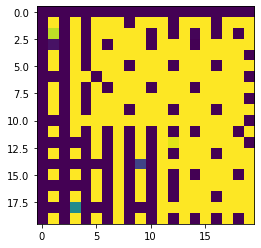

In [13]:
random_latent_vectors = tf.random.normal(shape=(1, latent_dim))
print(random_latent_vectors)
arg = tf.convert_to_tensor(np.array([[0,0,0,0,0,0]]), dtype=tf.float32)
generated_images = generator(random_latent_vectors)
generated_images *= 255
generated_images.numpy()
for i in range(1):
    img = generated_images[i,:,:,0]
    img = img[:,:,np.newaxis]
    img = keras.preprocessing.image.array_to_img(img)
    plt.imshow(img)